## Pairs Trading Assignment (v2.0)
Updated attempt to learn pairs trading. This is almost trash though and hence the names. Details to be added.

In [1]:
# %pip install niftystocks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from niftystocks import ns

import warnings
warnings.filterwarnings('ignore')

In [2]:
start_date = '2020-01-01'
end_date = '2022-12-31'

[*********************100%***********************]  10 of 10 completed


Ticker         ADANIGREEN.NS   BPCL.NS   GAIL.NS  HINDPETRO.NS    IOC.NS  \
Ticker                                                                     
ADANIGREEN.NS       1.000000  0.345808  0.789710      0.626359  0.707868   
BPCL.NS             0.345808  1.000000  0.672219      0.802523  0.620714   
GAIL.NS             0.789710  0.672219  1.000000      0.826927  0.900748   
HINDPETRO.NS        0.626359  0.802523  0.826927      1.000000  0.891917   
IOC.NS              0.707868  0.620714  0.900748      0.891917  1.000000   
NTPC.NS             0.768337  0.329501  0.807032      0.674525  0.893806   
ONGC.NS             0.772157  0.539641  0.905352      0.850648  0.969578   
POWERGRID.NS        0.882319  0.385192  0.865867      0.739819  0.905998   
RELIANCE.NS         0.899622  0.454083  0.714573      0.636801  0.685567   
TATAPOWER.NS        0.896250  0.477992  0.875533      0.809211  0.920242   

Ticker          NTPC.NS   ONGC.NS  POWERGRID.NS  RELIANCE.NS  TATAPOWER.NS  
Ticker    

<Axes: xlabel='Ticker', ylabel='Ticker'>

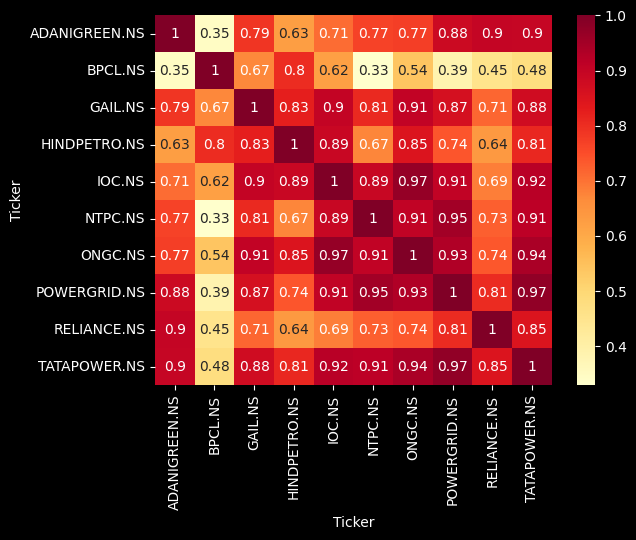

In [3]:
stocks = ns.get_nifty_energy_with_ns()
prices = yf.download(stocks, start = start_date, end = end_date)['Close']
log_prices = np.log(prices)
log_prices.dropna(axis=1, inplace=True)

print(log_prices.corr())
sns.heatmap(log_prices.corr(), annot = True, cmap ='YlOrRd')

In [4]:
pairs_first_draft = pd.DataFrame(columns=['stock1', 'stock2', 'corr'])
stock1_list, stock2_list, corr_list = [], [], []

for i in range(log_prices.shape[1]):
    for j in range(i+1, log_prices.shape[1]):
        check = log_prices.corr().iat[i,j]
        if (check >= 0.9):
            stock1_list.append(log_prices.columns[i])
            stock2_list.append(log_prices.columns[j])
            corr_list.append(check)
            

pairs_first_draft['stock1']=stock1_list
pairs_first_draft['stock2']=stock2_list
pairs_first_draft['corr']=corr_list

pairs_first_draft

,stock1,stock2,corr
0,GAIL.NS,IOC.NS,0.900748
1,GAIL.NS,ONGC.NS,0.905352
2,IOC.NS,ONGC.NS,0.969578
3,IOC.NS,POWERGRID.NS,0.905998
4,IOC.NS,TATAPOWER.NS,0.920242
5,NTPC.NS,ONGC.NS,0.907219
6,NTPC.NS,POWERGRID.NS,0.951670
7,NTPC.NS,TATAPOWER.NS,0.914320
8,ONGC.NS,POWERGRID.NS,0.934412
9,ONGC.NS,TATAPOWER.NS,0.941851


In [5]:
# %pip install statsmodels
# %pip install scipy

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import coint

We'll select the pair with the smallest $p$-value.

In [6]:
p_value = []

# p-values of the log returns

for i in range(pairs_first_draft.shape[0]):
    s1 = np.log(log_prices[pairs_first_draft['stock1'][i]])
    s2 = np.log(log_prices[pairs_first_draft['stock2'][i]])
    check = coint(s1,s2)[1]
    p_value.append(check)

pairs_first_draft['p-val'] = p_value

pairs_second_draft = pairs_first_draft.sort_values(by='p-val', ignore_index=True, ascending=True)

print(pairs_second_draft)

          stock1        stock2      corr     p-val
0         IOC.NS       ONGC.NS  0.969578  0.003881
1        ONGC.NS  POWERGRID.NS  0.934412  0.038038
2        ONGC.NS  TATAPOWER.NS  0.941851  0.041498
3        NTPC.NS  POWERGRID.NS  0.951670  0.047712
4         IOC.NS  POWERGRID.NS  0.905998  0.050058
5         IOC.NS  TATAPOWER.NS  0.920242  0.050216
6        GAIL.NS        IOC.NS  0.900748  0.088731
7   POWERGRID.NS  TATAPOWER.NS  0.974091  0.140114
8        GAIL.NS       ONGC.NS  0.905352  0.298811
9        NTPC.NS  TATAPOWER.NS  0.914320  0.433792
10       NTPC.NS       ONGC.NS  0.907219  0.702135


In [7]:
# Regression fit and spread
# y = gamma * x + c + z(spread)
# the hedge ratio here is gamma, given by res.params[1]

stock_pair = [pairs_second_draft['stock1'][0], pairs_second_draft['stock2'][0]]
res = OLS(log_prices[stock_pair[0]], add_constant(log_prices[stock_pair[1]])).fit()
hedge_ratio = res.params[1]

# we proceed to test now using the above hedge ratio
# in a different timeperiod <--- bad & weird

start_date = '2023-01-01'
end_date = '2025-03-31'

price_pair = yf.download(stock_pair, start=start_date, end=end_date)['Close']
price_pair_log = np.log(price_pair)
price_pair.head()

[*********************100%***********************]  2 of 2 completed


Ticker,IOC.NS,ONGC.NS
Date,,
2023-01-02,67.603844,128.953857
2023-01-03,68.037209,128.182495
2023-01-04,67.690521,125.353935
2023-01-05,68.557236,125.568245
2023-01-06,69.380623,126.296799


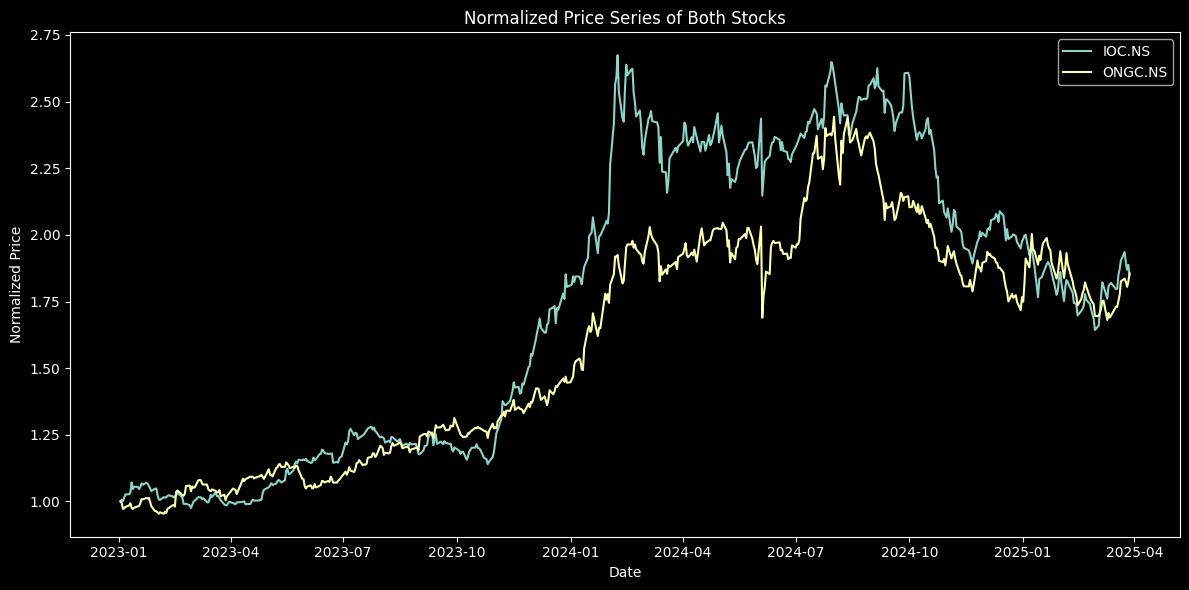

In [8]:
plt.figure(figsize=(12,6))
sns.lineplot(price_pair/price_pair.iloc[0], dashes=False)
plt.title('Normalized Price Series of Both Stocks')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

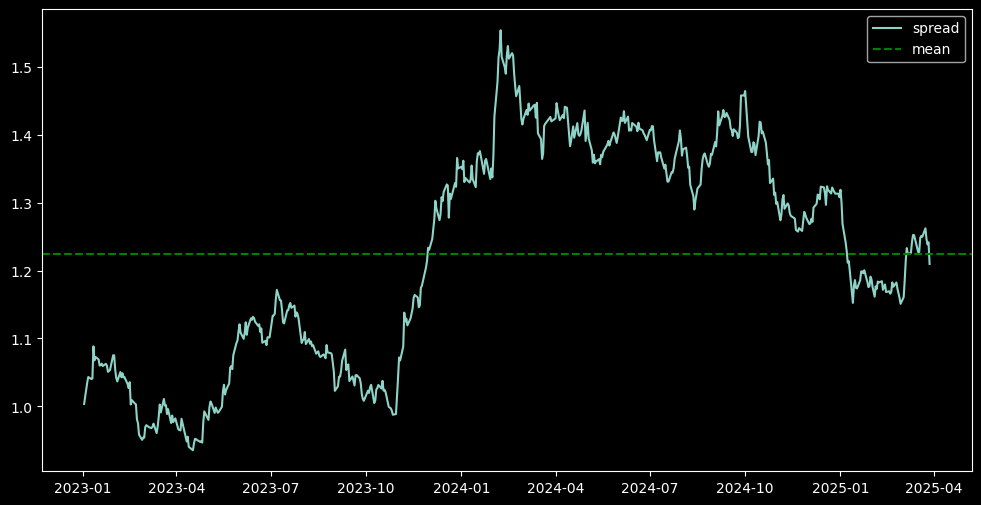

In [9]:
spread = price_pair_log[stock_pair[0]] - hedge_ratio*price_pair_log[stock_pair[1]]

plt.figure(figsize=(12,6))
plt.plot(spread, label='spread')
plt.axhline(y=spread.mean(), color='green', linestyle='dashed', label='mean')
plt.legend()

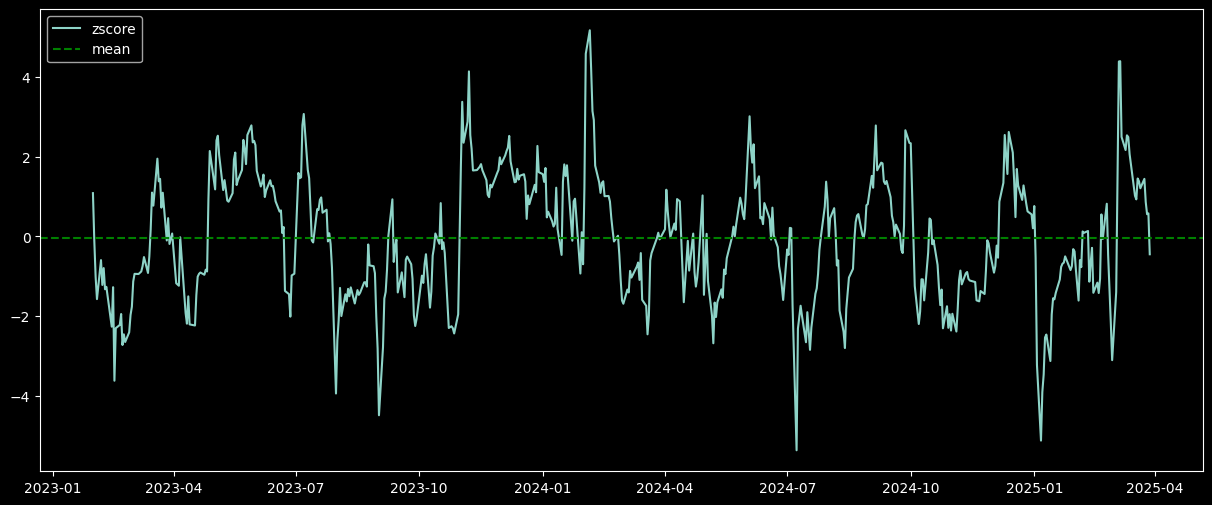

In [10]:
window = 20 # 20-day rolling mean of zscore
zscore = []
for i in range(window, len(spread)):
    calc = spread[i-window:i]
    zscore.append((spread[i]-calc.mean())/calc.std())
zscore = pd.Series(zscore, index = spread.index[window:])

plt.figure(figsize=(15,6))
plt.plot(zscore, label='zscore')
plt.axhline(y=zscore.mean(), color='green', linestyle='dashed', label='mean')
plt.legend()

### Step 3: Strategy and Backtesting

Set the threshold at z-score equal to 0.6 (I came up with trial and error, better optimizations in future versions).
If zscore > 0.6 => the first stock is growing away from the mean and so it will fall back and hence sell it, and buy the second stock. zscore < -0.6 => buy first stock, sell second

In [11]:
price_pair['zscore'] = zscore

conditions = [
  price_pair['zscore'] > 0.6,
  price_pair['zscore'] < -0.6,
]

choices = [-1, 1]

price_pair['signal'] = np.select(conditions, choices, default=0) 
# signal generation based on the z-score

price_pair.loc[abs(price_pair['zscore']) > 1, 'signal'] = 0 # stop-loss

# price_pair['pos_1'] = -price_pair['signal'].diff()
# price_pair['pos_2'] = -price_pair['pos_1']

price_pair.head(10)

Ticker,IOC.NS,ONGC.NS,zscore,signal
Date,,,,
2023-01-02,67.603844,128.953857,NaN,0
2023-01-03,68.037209,128.182495,NaN,0
2023-01-04,67.690521,125.353935,NaN,0
2023-01-05,68.557236,125.568245,NaN,0
2023-01-06,69.380623,126.296799,NaN,0
2023-01-09,69.423950,126.982475,NaN,0
2023-01-10,69.857307,128.011063,NaN,0
2023-01-11,72.414124,125.825394,NaN,0
2023-01-12,70.724022,125.268272,NaN,0


In [12]:
investment = 100000
capital_two = investment/2
capital_one = investment - capital_two

share_one = capital_one//(price_pair[stock_pair[0]].iloc[0])
share_two = capital_two//(price_pair[stock_pair[1]].iloc[0])

pft = pd.DataFrame()
pft['ret_1'] = price_pair[stock_pair[0]].diff()*price_pair['signal'].shift(1)*share_one
pft['net_1'] = capital_one + pft['ret_1'].cumsum()

pft['ret_2'] = -price_pair[stock_pair[1]].diff()*price_pair['signal'].shift(1)*share_two
pft['net_2'] = capital_two + pft['ret_2'].cumsum()


pft['net'] = pft['net_1'] + pft['net_2']

In [13]:
# %pip install quantstats
import quantstats

print(f"Net profit: {100*(pft['net'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(pft['net'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(pft['net']):.3f}")

Net profit: 28.788 %
Maximum drawdown: -5.674 %
Sharpe ratio: 1.255


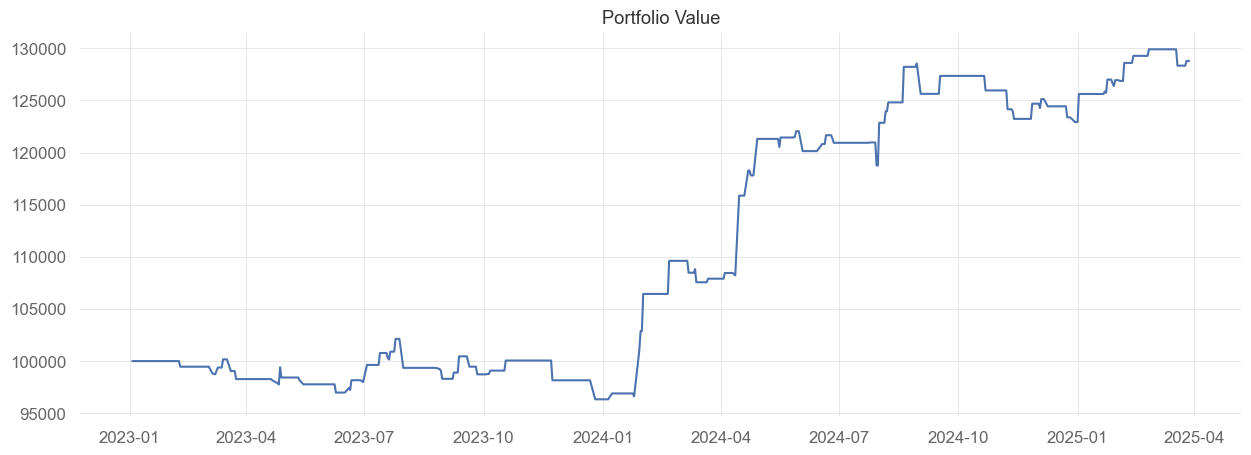

In [14]:
plt.figure(figsize=(15,5))
plt.title("Portfolio Value")
plt.plot(pft['net'])
plt.show()

We got sharpe ratio 1.2 and net profit of 28% which is good ig? Idk. We will now compare against 'buy & hold' of both stocks individually and then 50-50 investment distribution.

In [15]:
price_pair['ret_stock0'] = price_pair[stock_pair[0]].pct_change() 
price_pair['ret_stock1'] = price_pair[stock_pair[1]].pct_change() 

price_pair['bh_s0_val'] = investment * (1 + price_pair['ret_stock0']).cumprod() #buy&hold stock 0
price_pair['bh_s1_val'] = investment * (1 + price_pair['ret_stock1']).cumprod() #buy&hold stock 1

price_pair['bh_port_val'] = investment * (1 + (0.5 * price_pair['ret_stock0'] + 0.5 * price_pair['ret_stock1'])).cumprod() # invest 50-50 in both

In [16]:
print(f"Net profit in Buy&Hold Stock 0: {100*(price_pair['bh_s0_val'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(price_pair['bh_s0_val'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(price_pair['bh_s0_val']):.3f}")

Net profit in Buy&Hold Stock 0: 84.895 %
Maximum drawdown: -38.548 %
Sharpe ratio: 1.066


In [17]:
print(f"Net profit in Buy&Hold Stock 1: {100*(price_pair['bh_s1_val'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(price_pair['bh_s1_val'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(price_pair['bh_s1_val']):.3f}")

Net profit in Buy&Hold Stock 1: 85.516 %
Maximum drawdown: -31.228 %
Sharpe ratio: 1.097


In [18]:
print(f"Net profit in Buy&Hold 50-50: {100*(price_pair['bh_port_val'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(price_pair['bh_port_val'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(price_pair['bh_port_val']):.3f}")

Net profit in Buy&Hold 50-50: 89.009 %
Maximum drawdown: -33.468 %
Sharpe ratio: 1.213


That's truly depressing. 28% with pairs trading. Around 85% with simple buy&hold with almost similar Sharpe ratio values. The maximum drawdown is better in pairs trading though. I will update this flawed pairs_trading implementation in the other notebook.